# Imports

In [1]:
#!pip install sklearn matplotlib

In [1]:
import spacy
import pandas as pd
import numpy as np
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.vectors import Vectors
from tqdm import tqdm
tqdm.pandas()

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data

In [20]:
df = pd.read_pickle("DATA/reddit_wsb_sentiment.pkl").head(1000)
df['created'] = pd.to_datetime(df['created'], unit="s")
titles = df["title"]
bodies = df["body"].dropna()
df["text"] = df["title"].str.cat(df["body"], sep=" ### ", na_rep="(Empty body)")

df.head()

,title,score,id,url,comms_num,created,body,timestamp,text,sentiment
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,2021-01-28 19:37:41,NaN,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",0.0000
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,2021-01-28 19:32:10,NaN,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,-0.7034
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,2021-01-28 19:30:35,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,Exit the system ### The CEO of NASDAQ pushed t...,-0.4199
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,2021-01-28 19:28:57,NaN,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,-0.4822
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,2021-01-28 19:26:56,NaN,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",0.2235


We'll use the following example sentence

In [21]:
sentence = df["text"].iloc[15]
sentence

'420 wasn’t a meme. GME 🚀 🚀 🚀 ### (Empty body)'

# Calculate simple target

In [22]:
df["sentiment_category"] = pd.qcut(df["sentiment"],[0,0.3,0.7,1], labels=["negative", "neutral", "positive"])
df["sentiment_category"].value_counts()

neutral     401
negative    300
positive    299
Name: sentiment_category, dtype: int64

## Clean data

In [23]:
punctuations = string.punctuation

nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatise + lower case
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

spacy_tokenizer(sentence)

['420', 'meme', 'gme', '🚀', '🚀', '🚀', 'body']

In [24]:
def embed_words(sentence):
    tokens = spacy_tokenizer(sentence)
    return nlp.vocab.vectors.get_batch(tokens)

word_embeddings = embed_words(sentence)
print(word_embeddings)
print(word_embeddings.shape)

[[ -1.3111    -2.2037     0.65573  ...   2.6366    -1.0796     5.2409  ]
 [  1.799      0.067666   1.1057   ...   1.0487    -3.508     -1.0316  ]
 [ -4.5944    -1.4746     0.51068  ...  -3.5714     3.0194    -0.11818 ]
 ...
 [  1.7872    -8.747     -1.8549   ...  -3.3436     4.5346     6.3035  ]
 [  1.7872    -8.747     -1.8549   ...  -3.3436     4.5346     6.3035  ]
 [  0.49034    0.11765  -10.686    ...  -0.25644   -0.87749    2.2443  ]]
(7, 300)


## Simple model: just average the words

0

In [59]:
def embed_sentence_simple(sentence):
    """
    This is the part where you can go crazy and complex to add features, change aggregation way, use PCA, ...
    """
    word_embeddings = embed_words(sentence)
    sentence_embedding = np.concatenate([word_embeddings.min(axis=0), 
                                         word_embeddings.max(axis=0), 
                                         [embed_words(sentence).shape[0], 
                                         len([token for token in nlp(sentence) if token.is_oov])]])
    # sentence_embedding = np.concatenate(word_embeddings.min(axis=0), word_embeddings.max(axis=0))
    # sentence_embedding = word_embeddings.mean(axis=0)
    return sentence_embedding

sentence_embedding = embed_sentence_simple(sentence)
print(sentence_embedding)
print(sentence_embedding.shape)

[ -4.59439993  -8.74699974 -10.68599987 -11.42800045  -1.23469996
  -2.34879994  -0.40612     -1.25080001  -1.97570002  -2.98029995
  -5.47860003  -4.21600008  -5.50719976  -1.1631      -4.72900009
  -4.80380011  -0.86168998  -6.58769989  -5.30740023  -8.11699963
  -3.16149998  -0.73079002  -3.83049989  -9.00829983  -3.5632
  -7.61359978  -3.7901001   -3.78419995  -3.68420005  -5.78879976
  -5.75699997  -4.82070017  -5.51039982  -8.31389999  -2.02880001
  -4.14459991  -2.54949999  -5.42030001  -0.38593999  -4.39459991
  -2.19129992  -6.22730017  -4.78350019  -2.33520007  -1.28970003
  -0.80923998  -4.66550016  -3.28180003  -7.42089987  -3.76200008
  -5.42309999  -3.07399988  -9.77840042  -2.88630009  -1.47090006
  -3.3368001   -3.0165       0.79370999  -3.06529999  -0.96210003
  -3.65079999  -1.71619999  -7.98339987  -2.57969999  -5.96659994
  -5.76030016  -7.4229002   -7.72679996   0.080463    -1.99249995
  -5.87559986  -2.08310008  -1.45150006  -1.13279998  -1.49950004
  -2.68560004 

In [60]:
%%time

df["features_simple"] = df["text"].progress_map(embed_sentence_simple)

# Takes ~20 minutes so we cache the results now.
# df.to_pickle("DATA/reddit_wsb_sentiment_features.pkl")

100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.71it/s]

CPU times: user 49.5 s, sys: 1.23 s, total: 50.7 s
Wall time: 50.7 s


In [10]:
# Load cached results
# df = pd.read_pickle("DATA/reddit_wsb_sentiment_features.pkl")

## Classify

In [61]:
X = np.stack(df["features_simple"].values)
X.shape

(1000, 602)

In [62]:
y = df["sentiment_category"]

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (750, 602)
X_test shape: (250, 602)
y_train shape: (750,)
y_test shape: (250,)


In [68]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=22141, class_weight="balanced", n_estimators=300)
clf.fit(X_train, y_train)



CPU times: user 406 ms, sys: 6.41 ms, total: 413 ms
Wall time: 414 ms


RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=300,
                       random_state=22141)

## Evaluate

In [69]:

predictions = clf.predict(X_test)

              precision    recall  f1-score   support

    negative       0.40      0.31      0.35        71
     neutral       0.66      0.64      0.65       110
    positive       0.47      0.61      0.53        69

    accuracy                           0.54       250
   macro avg       0.51      0.52      0.51       250
weighted avg       0.53      0.54      0.53       250



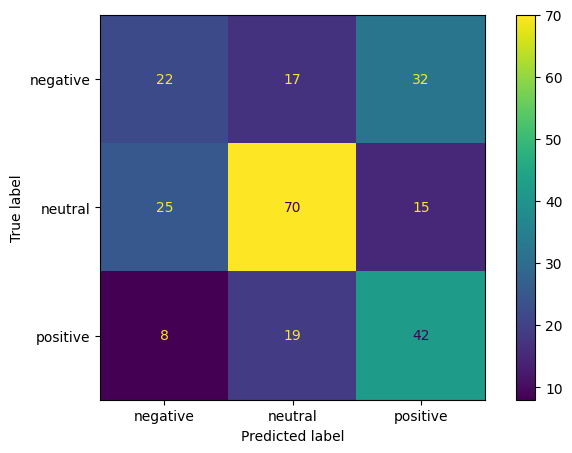

In [70]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
print(classification_report(y_test, predictions))
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, predictions),
    display_labels=clf.classes_,
)

cmp.plot(ax=ax)
plt.show();

## What's next?

The example above is to illustrate the theory of embeddings. In reality, you can build pipelines super easily with SpaCy (if you prioritize speed) or HuggingFace transfomers (if you prioritize accuracy)

https://medium.com/@ycouble/training-and-integrating-a-custom-text-classifier-to-a-spacy-pipeline-b19e6a132487